### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import sklearn

In [2]:
df = pd.read_csv('train.csv')
df = pd.DataFrame(df)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Checking for null values

In [3]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### Cleaning the text

In [4]:
import re
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()
df['cleaned_comment'] = df['comment_text'].apply(clean_text)
df.drop(columns=['comment_text', 'id'], inplace=True)
df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment
0,0,0,0,0,0,0,explanation\nwhy the edits made under my usern...
1,0,0,0,0,0,0,daww he matches this background colour im seem...
2,0,0,0,0,0,0,hey man im really not trying to edit war its j...
3,0,0,0,0,0,0,\nmore\ni cant make any real suggestions on im...
4,0,0,0,0,0,0,you sir are my hero any chance you remember wh...


### Checking for any imbalance 

In [5]:
df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

### Computing class weight for each label

In [6]:
from sklearn.utils import class_weight

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_weights = {}

for col in label_cols:
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[col]),
        y=df[col]
    )
    class_weights[col] = dict(enumerate(weights))
class_weights

{'toxic': {0: np.float64(0.5530022110246262),
  1: np.float64(5.216784359879691)},
 'severe_toxic': {0: np.float64(0.5050482351749633),
  1: np.float64(50.02225705329153)},
 'obscene': {0: np.float64(0.5279542356506663),
  1: np.float64(9.443188543022844)},
 'threat': {0: np.float64(0.5015022659702186),
  1: np.float64(166.9152719665272)},
 'insult': {0: np.float64(0.5259634527403853),
  1: np.float64(10.128919639456646)},
 'identity_hate': {0: np.float64(0.5044415361076338),
  1: np.float64(56.78683274021353)}}

In [7]:
# Create a weight matrix: shape (6, 2) for 6 labels and 2 classes (0 and 1)
weight_matrix = np.array([[class_weights[label][0], class_weights[label][1]] for label in label_cols])
weight_tensor = tf.constant(weight_matrix, dtype=tf.float32)

In [8]:
def multilabel_weighted_loss(y_true, y_pred):
   
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Binary crossentropy: shape (batch_size, 6)
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)

    # Extract weights for class 0 and class 1
    w0 = weight_matrix[:, 0]  # shape: (6,)
    w1 = weight_matrix[:, 1]  # shape: (6,)

    # Broadcast weights across batch
    weights = y_true * w1 + (1 - y_true) * w0  # shape: (batch_size, 6)

    # Apply weights to loss
    weighted_loss = bce * weights

    return tf.reduce_mean(weighted_loss)

# LSTM Model

### Dataset splitting and cleaning

In [9]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import pandas as pd
import re

X = df['cleaned_comment']
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

X_np = np.array(X).reshape(-1, 1)
y_np = y.values

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X_np, y_np, test_size=0.3)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

X_train = [clean_text(str(x[0])) for x in X_train]
X_val = [clean_text(str(x[0])) for x in X_val]
X_test = [clean_text(str(x[0])) for x in X_test]

### Creating labels

In [11]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = df[label_cols].values

### Tokenizing and padding

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [14]:
import numpy as np
print(np.max(X_test_pad))  # Should be < 15000

14998


In [15]:
y_train = np.array(y_train).astype('float32')
y_val = np.array(y_val).astype('float32')

### Computing class weight

In [16]:
from sklearn.utils import class_weight

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_weights = {}

for col in label_cols:
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[col]),
        y=df[col]
    )
    class_weights[col] = dict(enumerate(weights))

# Convert to matrix
weight_matrix = np.array([[class_weights[label][0], class_weights[label][1]] for label in label_cols])

In [17]:
weight_matrix_tf = tf.constant(weight_matrix, dtype=tf.float32)

def multilabel_weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)

    w0 = weight_matrix_tf[:, 0]
    w1 = weight_matrix_tf[:, 1]

    weights = y_true * w1 + (1 - y_true) * w0
    weighted_loss = bce * weights

    return tf.reduce_mean(weighted_loss)

### Building embedding matrix using GloVe

In [19]:
embedding_index = {}
with open("E:\\guvi\\Project_4\\glove.6B\\glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(15000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Creating the model with pre-trained embeddings

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],
              trainable=False),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(6, activation='sigmoid')
])

c:\Users\krith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Compile the model

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
X_train_pad = np.array(X_train_pad)
y_train = np.array(y_train).astype(np.float32)
X_val_pad = np.array(X_val_pad)
y_val = np.array(y_val).astype(np.float32)
X_test_pad = np.array(X_test_pad)
y_test = np.array(y_test).astype(np.float32)

In [23]:
print(np.any(np.isnan(X_train_pad)), np.any(np.isnan(y_train)))
print(np.any(np.isinf(X_train_pad)), np.any(np.isinf(y_train)))

False False
False False


### Model training

In [24]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train.astype(np.float32),
    validation_data=(X_val_pad, y_val.astype(np.float32)),
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 131s 37ms/step - accuracy: 0.9069 - loss: 0.1596 - val_accuracy: 0.9945 - val_loss: 0.1407
Epoch 2/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 247s 71ms/step - accuracy: 0.9939 - loss: 0.1404 - val_accuracy: 0.9945 - val_loss: 0.1218
Epoch 3/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 144s 41ms/step - accuracy: 0.9942 - loss: 0.0951 - val_accuracy: 0.9945 - val_loss: 0.0771
Epoch 4/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 165s 47ms/step - accuracy: 0.9942 - loss: 0.0817 - val_accuracy: 0.9945 - val_loss: 0.0781
Epoch 5/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 138s 40ms/step - accuracy: 0.9942 - loss: 0.0787 - val_accuracy: 0.9945 - val_loss: 0.0606
Epoch 6/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 140s 40ms/step - accuracy: 0.9942 - loss: 0.0618 - val_accuracy: 0.9945 - val_loss: 0.0603
Epoch 7/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 269s 77ms/step - accuracy: 0.9942 - loss: 0.0585 - val_accuracy: 0.9945 - val_loss: 0.0590
Epoch 8/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 222s 63ms/step - accuracy: 

### Evaluate the model

In [25]:
loss, acc = model.evaluate(X_test_pad, y_test, verbose=2)
print("Test Accuracy:", acc)

748/748 - 9s - 12ms/step - accuracy: 0.9938 - loss: 0.0532
Test Accuracy: 0.9938168525695801


### Making the predictions with validation dataset

In [26]:
y_pred_proba = model.predict(X_val_pad)

748/748 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step


### Threshold tuning, classification report, confusion matrix

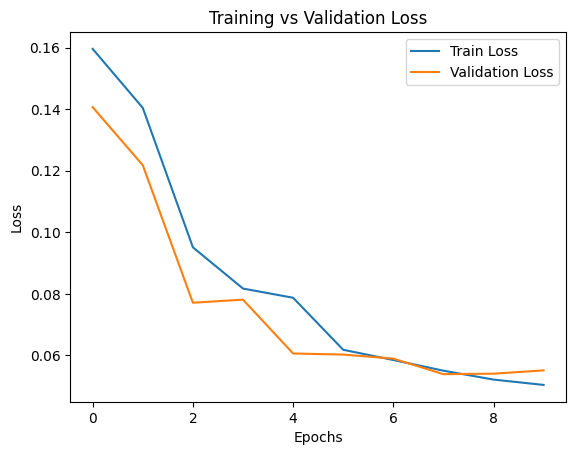

748/748 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
748/748 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
[2178  764 1162    0 1405 1086]
               precision    recall  f1-score   support

        toxic       0.81      0.77      0.79      2294
 severe_toxic       0.24      0.77      0.36       239
      obscene       0.83      0.76      0.80      1268
       threat       0.00      0.00      0.00        72
       insult       0.66      0.78      0.72      1182
identity_hate       0.13      0.67      0.21       207

    micro avg       0.60      0.76      0.67      5262
    macro avg       0.45      0.62      0.48      5262
 weighted avg       0.72      0.76      0.72      5262
  samples avg       0.05      0.07      0.06      5262



c:\Users\krith\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\krith\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\krith\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

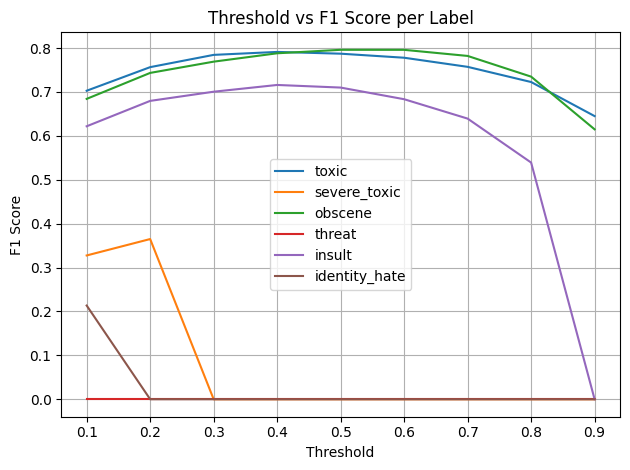

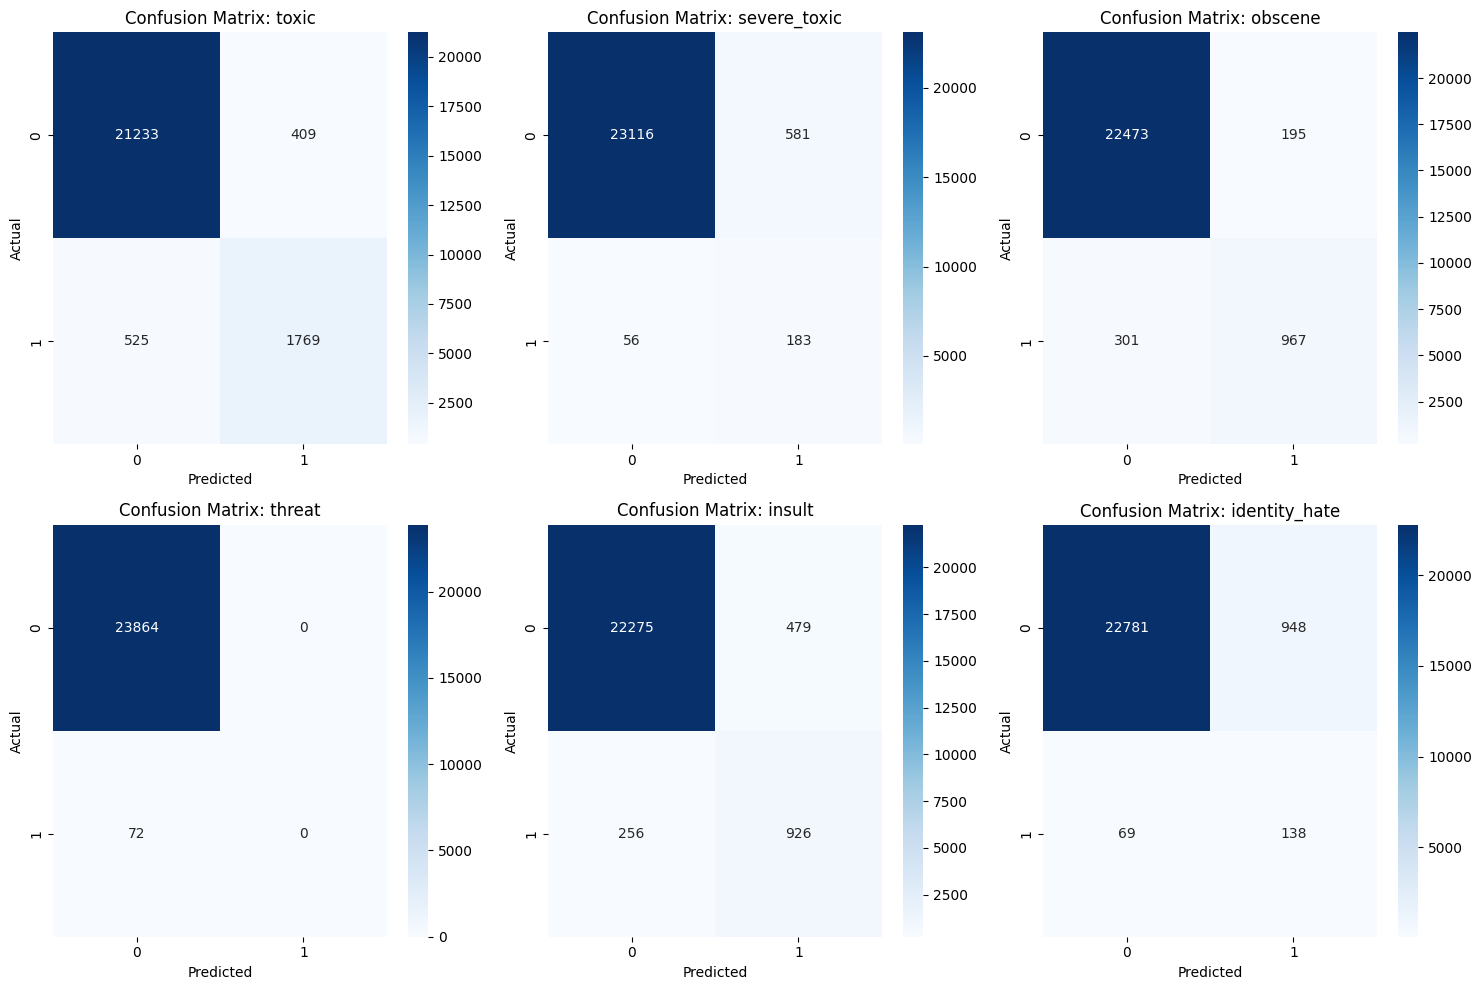

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Threshold tuning
y_pred_proba = model.predict(X_val_pad)
best_thresholds = []

for i in range(y_val.shape[1]):
    thresholds = np.linspace(0.1, 0.9, 9)
    f1_scores = [f1_score(y_val[:, i], (y_pred_proba[:, i] > t).astype(int), zero_division=0) for t in thresholds]
    best_thresholds.append(thresholds[np.argmax(f1_scores)])

# Apply thresholds
y_test_probs = model.predict(X_test_pad)
thresholds = np.array(best_thresholds)
y_test_pred = (y_test_probs > thresholds).astype(int)

# Report
print(np.sum(y_test_pred, axis=0))
print(classification_report(y_test, y_test_pred, target_names=y.columns))

# F1 vs Threshold plot
for i, label in enumerate(y.columns):
    thresholds = np.linspace(0.1, 0.9, 9)
    f1s = [f1_score(y_test[:, i], (y_test_probs[:, i] > t).astype(int), zero_division=0) for t in thresholds]
    plt.plot(thresholds, f1s, label=label)

plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold vs F1 Score per Label")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, label in enumerate(y.columns):
    cm = confusion_matrix(y_test[:, i], y_test_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix: {label}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [28]:
import pickle
model.save("toxicity_model/lstm_glove_model.h5")

with open("toxicity_model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

np.save("toxicity_model/best_thresholds.npy", np.array(best_thresholds))

# CNN

### Splitting dataset

In [29]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import pandas as pd
import re

X = df['cleaned_comment']
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

X_np = np.array(X).reshape(-1, 1)
y_np = y.values

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X_np, y_np, test_size=0.3)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

X_train = [str(x[0]) for x in X_train]
X_val = [str(x[0]) for x in X_val]
X_test = [str(x[0]) for x in X_test]

### Tokenization

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

### Building embedding matrix using GloVe

In [32]:
embedding_index = {}
with open(r"E:\guvi\Project_4\glove.6B\glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(15000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Computing the class weights

In [33]:
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import backend as K

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
cnn_class_weights = {}

for col in label_cols:
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[col]),
        y=df[col]
    )
    cnn_class_weights[col] = dict(enumerate(weights))

cnn_weight_matrix = np.array([[cnn_class_weights[label][i] for i in range(2)] for label in label_cols])
cnn_weight_tensor = tf.constant(cnn_weight_matrix, dtype=tf.float32)

def cnn_weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    base_loss = K.binary_crossentropy(y_true, y_pred)
    w0 = cnn_weight_tensor[:, 0]
    w1 = cnn_weight_tensor[:, 1]
    weights = y_true * w1 + (1 - y_true) * w0
    weighted_loss = base_loss * weights
    return tf.reduce_mean(weighted_loss)

### Model with pre-trained embeddings

In [34]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.regularizers import l2

cnn_model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],
              trainable=False),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(6, activation='sigmoid')
])

c:\Users\krith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
cnn_model.compile(optimizer='adam', loss=cnn_weighted_loss, metrics=['accuracy'])

### Model training

In [36]:
cnn_model.compile(optimizer='adam', loss=cnn_weighted_loss, metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

cnn_early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_history = cnn_model.fit(
    X_train_pad, y_train.astype(np.float32),
    validation_data=(X_val_pad, y_val.astype(np.float32)),
    epochs=50,
    batch_size=32,
    callbacks=[cnn_early_stop]
)

Epoch 1/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 74s 21ms/step - accuracy: 0.6343 - loss: 0.3587 - val_accuracy: 0.9875 - val_loss: 0.2373
Epoch 2/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 152s 44ms/step - accuracy: 0.9224 - loss: 0.2558 - val_accuracy: 0.9327 - val_loss: 0.2218
Epoch 3/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 48s 14ms/step - accuracy: 0.9415 - loss: 0.2351 - val_accuracy: 0.9829 - val_loss: 0.2149
Epoch 4/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9528 - loss: 0.2200 - val_accuracy: 0.9439 - val_loss: 0.2092
Epoch 5/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 86s 25ms/step - accuracy: 0.9570 - loss: 0.2120 - val_accuracy: 0.9567 - val_loss: 0.2083
Epoch 6/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 134s 38ms/step - accuracy: 0.9553 - loss: 0.2089 - val_accuracy: 0.9464 - val_loss: 0.2111
Epoch 7/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - accuracy: 0.9600 - loss: 0.1949 - val_accuracy: 0.9651 - val_loss: 0.2189
Epoch 8/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.9636 

In [37]:
# Evaluate on test set
loss, accuracy = cnn_model.evaluate(X_test_pad, y_test.astype(np.float32), verbose=2)
print("Test Accuracy:", accuracy)

748/748 - 2s - 3ms/step - accuracy: 0.9748 - loss: 0.2195
Test Accuracy: 0.9748077988624573


### Model evaluation, threshold, classification and confusion matrix

748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
               precision    recall  f1-score   support

        toxic       0.82      0.70      0.76      2294
 severe_toxic       0.25      0.82      0.39       240
      obscene       0.73      0.81      0.76      1267
       threat       0.22      0.76      0.34        72
       insult       0.60      0.77      0.67      1182
identity_hate       0.20      0.72      0.31       221

    micro avg       0.59      0.75      0.66      5276
    macro avg       0.47      0.76      0.54      5276
 weighted avg       0.69      0.75      0.70      5276
  samples avg       0.05      0.07      0.05      5276

748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


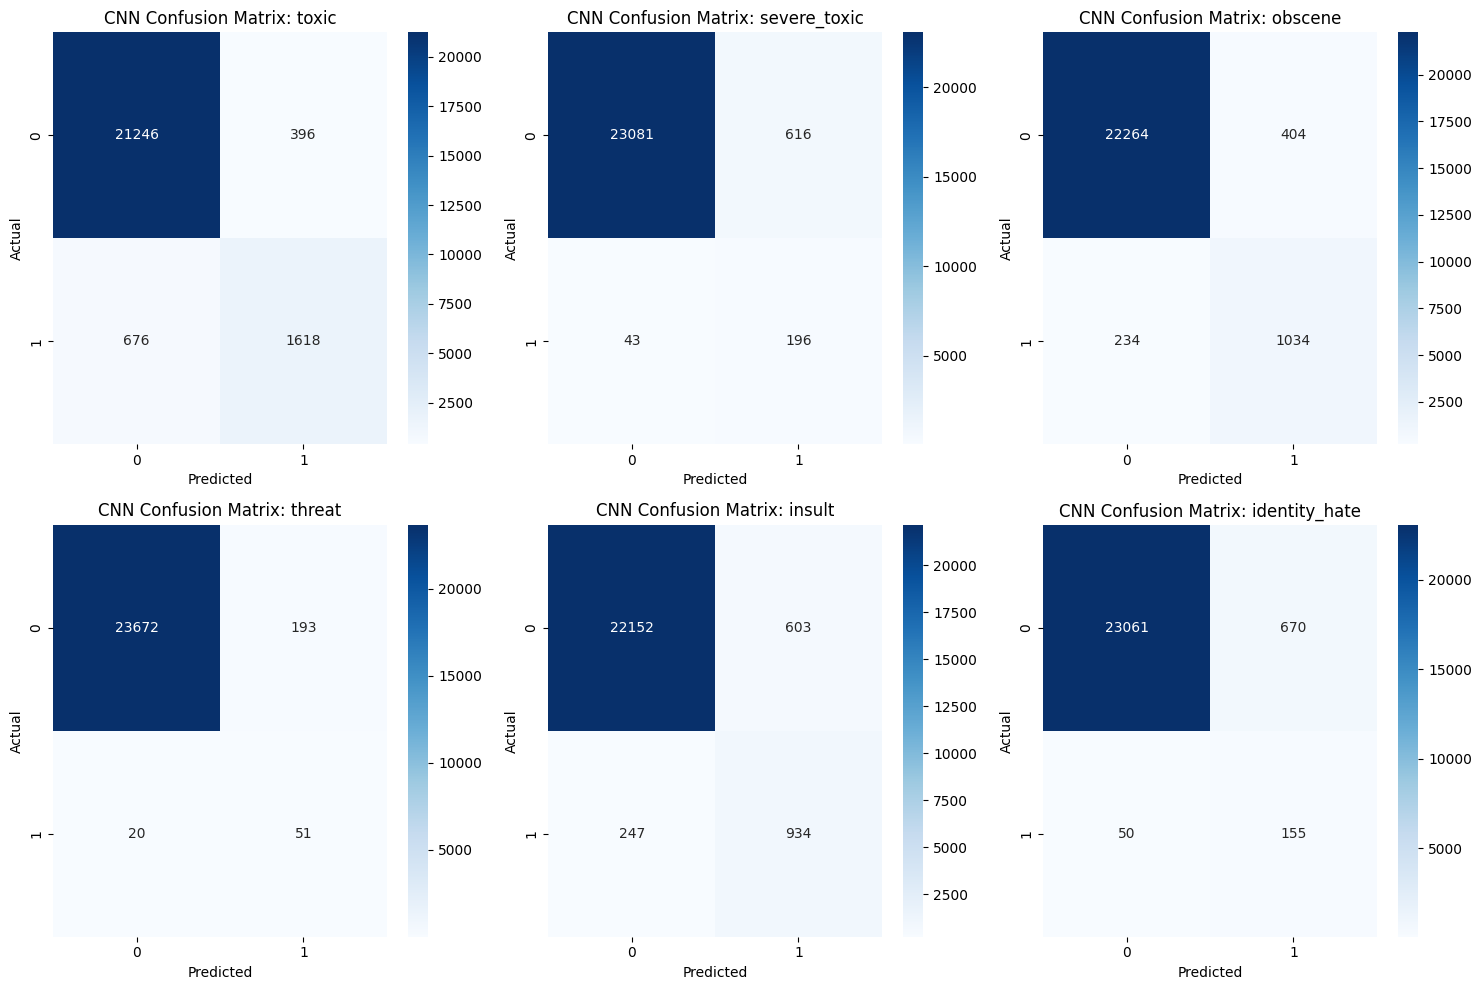

In [38]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cnn_y_val_probs = cnn_model.predict(X_val_pad)

cnn_best_thresholds = []
for i in range(y_val.shape[1]):
    thresholds = np.linspace(0.1, 0.9, 9)
    f1s = [f1_score(y_val[:, i], (cnn_y_val_probs[:, i] > t).astype(int), zero_division=0) for t in thresholds]
    cnn_best_thresholds.append(thresholds[np.argmax(f1s)])

cnn_y_val_pred = np.zeros_like(cnn_y_val_probs)
for i, t in enumerate(cnn_best_thresholds):
    cnn_y_val_pred[:, i] = (cnn_y_val_probs[:, i] > t).astype(int)

print(classification_report(y_val, cnn_y_val_pred, target_names=label_cols, zero_division=0))

cnn_y_test_probs = cnn_model.predict(X_test_pad)
cnn_y_test_pred = np.zeros_like(cnn_y_test_probs)
for i, t in enumerate(cnn_best_thresholds):
    cnn_y_test_pred[:, i] = (cnn_y_test_probs[:, i] > t).astype(int)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, label in enumerate(label_cols):
    cm = confusion_matrix(y_test[:, i], cnn_y_test_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'CNN Confusion Matrix: {label}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()